In [3]:
%matplotlib inline
import numpy
import numpy as np
import keras

import os
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, Input, Reshape, Permute, Average
from keras.layers import Conv2D, MaxPooling2D, Concatenate, Lambda, Activation, GlobalAveragePooling2D, Conv2DTranspose, GlobalAveragePooling1D
from keras.optimizers import SGD, Adam

# Data loading and preprocessing
### Mostly taken from baseline script given in project description
1. Images -> square patches of fixed size 
2. (?) Extract some features from images

## 0. Problem-specific parameters

In [4]:
NUM_CHANNELS = 3 # RGB images
PIXEL_DEPTH = 255
NUM_LABELS = 2
IMG_SIZE = 400
PATCH_SIZE = 16
WINDOW_SIZE = 32 # 18px - PATCH_SIZE - 18px
NB_WINDOWS = (IMG_SIZE/PATCH_SIZE)**2

## 1. Functions for image pre/post-processing

In [5]:
def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    imgs = []
    tmp_imgs = []
    for i in range(1, num_images+1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            img = Image.open(image_filename)
            tmp_imgs.append(img)
        else:
            print ('File ' + image_filename + ' does not exist')

    num_images = len(tmp_imgs)
    for i in range(num_images):
        imgs.append(np.asarray(tmp_imgs[i]) / 255)
        imgs.append(np.asarray(tmp_imgs[i].rotate(90)) / 255)
        imgs.append(np.asarray(tmp_imgs[i].rotate(180)) / 255)
        imgs.append(np.asarray(tmp_imgs[i].rotate(-90)) / 255)
        imgs.append(np.asarray(tmp_imgs[i].transpose(Image.FLIP_LEFT_RIGHT)) / 255)
        imgs.append(np.asarray(tmp_imgs[i].transpose(Image.FLIP_TOP_BOTTOM)) / 255)
        imgs.append(np.asarray(tmp_imgs[i].transpose(Image.TRANSPOSE)) / 255)
    num_images = len(imgs)
    IMG_WIDTH = imgs[0].shape[0]
    IMG_HEIGHT = imgs[0].shape[1]
    N_PATCHES_PER_IMAGE = (IMG_WIDTH/IMG_PATCH_SIZE)*(IMG_HEIGHT/IMG_PATCH_SIZE)
    print('Patches per images: ' + str(N_PATCHES_PER_IMAGE))

    img_patches = [img_crop(imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]

    data = np.array([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])

    return data

# Assign a label to a patch v
def value_to_class(v):
    foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch
    df = numpy.sum(v)
    if df > foreground_threshold:
        return 1 #return [0, 1]
    else:
        return 0 #return [1, 0]

def enhance_save(train_data, train_labels):
    data_copy = list(train_data)
    path = './windows_train_patch/'
    os.makedirs(path, exist_ok=True)
    for ind, im in enumerate(data_copy):
        cur_name = path + str(ind)
        plt.imsave(cur_name + "_" + str(train_labels[ind]) + ".png", im)
        plt.imsave(cur_name + "_" + str(train_labels[ind]) + "r90.png", np.rot90(im))
        plt.imsave(cur_name + "_" + str(train_labels[ind]) + "r180.png", np.rot90(im,k=2))        
        plt.imsave(cur_name + "_" + str(train_labels[ind]) + "r270.png", np.rot90(im,k=3))
        plt.imsave(cur_name + "_" + str(train_labels[ind]) + "flr.png", np.fliplr(im))
        plt.imsave(cur_name + "_" + str(train_labels[ind]) + "fud.png", np.flipud(im))
        plt.imsave(cur_name + "_" + str(train_labels[ind]) + "tr.png", np.transpose(im,(1, 0, 2)))
    
    del data_copy


# Extract label images
def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    gt_imgs = []
    tmp_imgs = []
    for i in range(1, num_images+1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            img = Image.open(image_filename)
            tmp_imgs.append(img)
        else:
            print ('File ' + image_filename + ' does not exist')

    num_images = len(tmp_imgs)
    for i in range(num_images):
        gt_imgs.append(np.asarray(tmp_imgs[i]) / 255)        
        gt_imgs.append(np.asarray(tmp_imgs[i].rotate(90)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].rotate(180)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].rotate(-90)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].transpose(Image.FLIP_LEFT_RIGHT)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].transpose(Image.FLIP_TOP_BOTTOM)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].transpose(Image.TRANSPOSE)) / 255)
    num_images = len(gt_imgs)
    gt_patches = [img_crop(gt_imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]
    data = numpy.array([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    labels = numpy.array([value_to_class(numpy.mean(data[i])) for i in range(len(data))])

    # Convert to dense 1-hot representation.
    return labels.astype(numpy.float32)

# Extract label images
def extract_gt(filename, num_images):
    gt_imgs = []
    tmp_imgs = []
    for i in range(1, num_images+1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            img = Image.open(image_filename)
            tmp_imgs.append(img)
        else:
            print ('File ' + image_filename + ' does not exist')

    num_images = len(tmp_imgs)
    for i in range(num_images):
        gt_imgs.append(np.asarray(tmp_imgs[i]) / 255)   
        gt_imgs.append(np.asarray(tmp_imgs[i].rotate(90)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].rotate(180)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].rotate(-90)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].transpose(Image.FLIP_LEFT_RIGHT)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].transpose(Image.FLIP_TOP_BOTTOM)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].transpose(Image.TRANSPOSE)) / 255)     
    num_images = len(gt_imgs)
    gt_patches = [img_crop(gt_imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]
    data = numpy.array([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    
    return data.astype(numpy.float32)


# Convert array of labels to an image
def label_to_img_win(imgwidth, imgheight, w, h, labels):
    array_labels = numpy.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if labels[idx] > 0.5:
                array_labels[i:i+w, j:j+h] = 1
            else:
                array_labels[i:i+w, j:j+h] = 0
            idx = idx + 1
    return array_labels

# Convert array of labels to an image
def label_to_img(imgwidth, imgheight, w, h, labels):
    array_labels = numpy.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if labels[idx] > 0.5:
                array_labels[j:j+w, i:i+h] = 1
            else:
                array_labels[j:j+w, i:i+h] = 0
            idx = idx + 1
    return array_labels

# Convert array of labels to an image
def label_to_img_soft(imgwidth, imgheight, w, h, labels):
    array_labels = numpy.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            array_labels[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return array_labels

def img_float_to_uint8(img):
    rimg = img - numpy.min(img)
    rimg = (rimg / numpy.max(rimg) * PIXEL_DEPTH).round().astype(numpy.uint8)
    return rimg

## 3. Load images from dataset, convert to inputs for model

Model parameters

In [6]:
IMG_PATCH_SIZE = 16
TRAINING_SIZE = 100
BATCH_SIZE = 32
NUM_EPOCHS = 30
a = 0.0001

In [7]:
data_dir = 'training/'
train_data_filename = data_dir + 'images/'
train_labels_filename = data_dir + 'groundtruth/' 

# Extract it into numpy arrays.
train_data = extract_data(train_data_filename, TRAINING_SIZE)
train_labels = extract_labels(train_labels_filename, TRAINING_SIZE)
train_gts = extract_gt(train_labels_filename, TRAINING_SIZE)

Patches per images: 625.0


In [8]:
train_data.shape, train_labels.shape, train_gts.shape

((437500, 16, 16, 3), (437500,), (437500, 16, 16))

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size = 0.1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((393750, 16, 16, 3), (43750, 16, 16, 3), (393750,), (43750,))

## Different ConvNet-based models

In [237]:
INPUT_SIZE = PATCH_SIZE

## DilatedNet

In [187]:
from keras.layers import Activation, Reshape, Dropout
from keras.layers import AtrousConvolution2D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential

def get_frontend(input_width, input_height) -> Sequential:
    model = Sequential()
    # model.add(ZeroPadding2D((1, 1), input_shape=(input_width, input_height, 3)))
    model.add(Conv2D(16, 1, 1, activation='relu', name='conv1_1', input_shape=(input_width, input_height, 3)))
    model.add(Conv2D(16, 1, 1, activation='relu', name='conv1_2'))
    model.add(Conv2D(16, 1, 1, activation='relu', name='conv2_1'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(32, 2, 2, activation='relu', name='conv2_2'))
    model.add(Conv2D(32, 2, 2, activation='relu', name='conv3_1'))

    '''model.add(AtrousConvolution2D(128, 3, 3, atrous_rate=(2, 2), activation='relu', name='conv5_1'))
    model.add(AtrousConvolution2D(128, 3, 3, atrous_rate=(2, 2), activation='relu', name='conv5_2'))'''

    model.add(AtrousConvolution2D(64, 3, 3, atrous_rate=(2, 2), activation='relu', name='fc6'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, 2, 2, activation='relu', name='fc7'))
    model.add(Dropout(0.5))
    # Note: this layer has linear activations, not ReLU
    model.add(Convolution2D(1, 1, 1, activation='linear', name='fc-final'))

    # model.layers[-1].output_shape == (None, 16, 16, 21)
    return model


def add_softmax(model: Sequential) -> Sequential:
    """ Append the softmax layers to the frontend or frontend + context net. """
    # The softmax layer doesn't work on the (width, height, channel)
    # shape, so we reshape to (width*height, channel) first.
    # https://github.com/fchollet/keras/issues/1169
    _, curr_width, curr_height, curr_channels = model.layers[-1].output_shape

    model.add(GlobalAveragePooling2D())
    model.add(Activation('sigmoid'))
    # Technically, we need another Reshape here to reshape to 2d, but TF
    # the complains when batch_size > 1. We're just going to reshape in numpy.
    # model.add(Reshape((curr_width, curr_height, curr_channels)))

    return model


def add_context(model: Sequential) -> Sequential:
    """ Append the context layers to the frontend. """
    model.add(ZeroPadding2D(padding=(33, 33)))
    model.add(Conv2D(42, 3, 3, activation='relu', name='ct_conv1_1'))
    model.add(Conv2D(42, 3, 3, activation='relu', name='ct_conv1_2'))
    model.add(AtrousConvolution2D(84, 3, 3, atrous_rate=(2, 2), activation='relu', name='ct_conv2_1'))
    model.add(AtrousConvolution2D(168, 3, 3, atrous_rate=(4, 4), activation='relu', name='ct_conv3_1'))
    model.add(AtrousConvolution2D(336, 3, 3, atrous_rate=(8, 8), activation='relu', name='ct_conv4_1'))
    model.add(AtrousConvolution2D(672, 3, 3, atrous_rate=(16, 16), activation='relu', name='ct_conv5_1'))
    model.add(Conv2D(672, 3, 3, activation='relu', name='ct_fc1'))
    model.add(Conv2D(21, 1, 1, name='ct_final'))

    return model

In [188]:
model = add_softmax(get_frontend(16, 16))

c:\tools\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1), activation="relu", name="conv1_1", input_shape=(16, 16, 3...)`
  
c:\tools\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1), activation="relu", name="conv1_2")`
  if __name__ == '__main__':
c:\tools\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1), activation="relu", name="conv2_1")`
  # Remove the CWD from sys.path while we load stuff.
c:\tools\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 2), activation="relu", name="conv2_2")`
  del sys.path[0]
c:\tools\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 2), activation="relu"

## DilNet-2

In [10]:
from keras.layers import Activation, Reshape, Dropout
from keras.layers import AtrousConvolution2D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential

def dilNet2(input_width, input_height) -> Sequential:
    model = Sequential()
    model.add(Conv2D(16, 2, activation='relu', input_shape=(input_width, input_height, 3)))
    model.add(Conv2D(16, 2, activation='relu'))
    model.add(Conv2D(16, 2, activation='relu'))
    
    model.add(Conv2D(32, 2, 2, activation='relu'))
    model.add(Conv2D(32, 2, 2, activation='relu'))
    model.add(Conv2D(32, 2, 2, activation='relu'))

    model.add(AtrousConvolution2D(64, 4, 4, atrous_rate=(2, 2), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, 2, 2, activation='relu'))
    model.add(Dropout(0.5))
    # Note: this layer has linear activations, not ReLU
    model.add(Convolution2D(1, 1, 1, activation='linear'))
    _, curr_width, curr_height, curr_channels = model.layers[-1].output_shape

    model.add(GlobalAveragePooling2D())
    model.add(Activation('sigmoid'))
    return model
model = dilNet2(16,16)

c:\tools\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 2), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
c:\tools\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 2), activation="relu")`
  if sys.path[0] == '':
c:\tools\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 2), activation="relu")`
  del sys.path[0]
c:\tools\anaconda3\lib\site-packages\keras\legacy\layers.py:757: UserWarning: The `AtrousConvolution2D` layer  has been deprecated. Use instead the `Conv2D` layer with the `dilation_rate` argument.
  warnings.warn('The `AtrousConvolution2D` layer '
c:\tools\anaconda3\lib\site-packages\keras\legacy\layers.py:761: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), activation="relu", di

#### FCN (again, from tutorial network)

In [267]:
model = Sequential()
model.add(Conv2D(32, 2, input_shape=(INPUT_SIZE, INPUT_SIZE, NUM_CHANNELS)))
model.add(LeakyReLU(alpha=a))
model.add(Conv2D(32, 2))
model.add(LeakyReLU(alpha=a))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, 2))
model.add(LeakyReLU(alpha=a))
model.add(Conv2D(32, 2))
model.add(LeakyReLU(alpha=a))
model.add(Conv2D(32, 2))
model.add(LeakyReLU(alpha=a))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 2))
model.add(LeakyReLU(alpha=a))
model.add(Conv2D(64, 1))
model.add(LeakyReLU(alpha=a))
model.add(Dropout(0.25))

model.add(Conv2DTranspose(1, kernel_size=IMG_PATCH_SIZE - 1, padding='valid'))
model.add(GlobalAveragePooling2D())
model.add(Activation('sigmoid'))

## Print model structure

In [11]:
for layer in model.layers:
    print(layer.input_shape,layer.output_shape )

(None, 16, 16, 3) (None, 15, 15, 16)
(None, 15, 15, 16) (None, 14, 14, 16)
(None, 14, 14, 16) (None, 13, 13, 16)
(None, 13, 13, 16) (None, 12, 12, 32)
(None, 12, 12, 32) (None, 11, 11, 32)
(None, 11, 11, 32) (None, 10, 10, 32)
(None, 10, 10, 32) (None, 4, 4, 64)
(None, 4, 4, 64) (None, 4, 4, 64)
(None, 4, 4, 64) (None, 3, 3, 64)
(None, 3, 3, 64) (None, 3, 3, 64)
(None, 3, 3, 64) (None, 3, 3, 1)
(None, 3, 3, 1) (None, 1)
(None, 1) (None, 1)


In [12]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.utils import plot_model
plot_model(model, to_file='DilNet2.png',show_shapes =True,show_layer_names=False)

Optimization

In [13]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [ ]:
LR = 0.001
DECAY = 0.00000
adam = Adam(lr=LR, decay=DECAY)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc',f1])

model.fit(X_train, 1-y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_test, 1-y_test))

Train on 393750 samples, validate on 43750 samples
Epoch 1/30
393750/393750 [==============================] - 311s - loss: 0.4317 - acc: 0.7941 - f1: 0.8653 - val_loss: 0.3890 - val_acc: 0.8159 - val_f1: 0.8744
Epoch 2/30
393750/393750 [==============================] - 310s - loss: 0.3918 - acc: 0.8140 - f1: 0.8750 - val_loss: 0.3958 - val_acc: 0.8113 - val_f1: 0.8755
Epoch 3/30
393750/393750 [==============================] - 483s - loss: 0.3797 - acc: 0.8204 - f1: 0.8791 - val_loss: 0.3678 - val_acc: 0.8316 - val_f1: 0.8869
Epoch 4/30
393750/393750 [==============================] - 313s - loss: 0.3718 - acc: 0.8262 - f1: 0.8829 - val_loss: 0.3804 - val_acc: 0.8151 - val_f1: 0.8809
Epoch 5/30
393750/393750 [==============================] - 299s - loss: 0.3650 - acc: 0.8308 - f1: 0.8861 - val_loss: 0.3644 - val_acc: 0.8332 - val_f1: 0.8920
Epoch 6/30
103552/393750 [======>.......................] - ETA: 203s - loss: 0.3594 - acc: 0.8340 - f1: 0.8882

In [273]:
model.save('DilNet_16_enh2.h5')

## Test predictions

In [262]:
import re

def extract_test_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    imgs = []
    names = []
    for i in range(1, num_images+1):
        imageid = "test_{}/test_{}".format(i,i)
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            #print ('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            imgs.append(img)
            names.append(image_filename)
        else:
            print ('File ' + image_filename + ' does not exist')
    return np.array(imgs), names

# Get prediction for given input image 
def keras_prediction(model, img):
    data = numpy.asarray(img_crop(img, IMG_PATCH_SIZE, IMG_PATCH_SIZE))
    output_prediction = model.predict(data)
    img_prediction = label_to_img(img.shape[0], img.shape[1], IMG_PATCH_SIZE, IMG_PATCH_SIZE, output_prediction)

    return img_prediction

# Get prediction for given input image 
def keras_prediction_av(model1, model2, img):
    data = numpy.asarray(img_crop(img, IMG_PATCH_SIZE, IMG_PATCH_SIZE))
    pred1 = model1.predict(data)
    pred2 = 1 - model2.predict(data)
    img_prediction = label_to_img(img.shape[0], img.shape[1], IMG_PATCH_SIZE, IMG_PATCH_SIZE, (pred1 + pred2) / 2)

    return img_prediction

# Get prediction for given input image 
def keras_prediction_av3(model1, model2, model3, img):
    data = numpy.asarray(img_crop(img, IMG_PATCH_SIZE, IMG_PATCH_SIZE))
    pred1 = model1.predict(data)
    pred2 = 1 - model2.predict(data)
    pred3 = 1 - model3.predict(data)
    img_prediction = label_to_img(img.shape[0], img.shape[1], IMG_PATCH_SIZE, IMG_PATCH_SIZE, (pred1 + pred2 + pred3) / 3)

    return img_prediction

# Get prediction for given input image 
def keras_prediction_win(model, img):
    img_wins = np.asarray(sliding_window(img, WINDOW_SIZE, IMG_PATCH_SIZE))
    output_prediction = model.predict(img_wins)
    img_prediction = label_to_img_win(img.shape[0], img.shape[1], IMG_PATCH_SIZE, IMG_PATCH_SIZE, output_prediction)

    return img_prediction

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0

def mask_to_submission_strings(im, im_name):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", im_name).group(0))
    for j in range(0, im.shape[1], IMG_PATCH_SIZE):
        for i in range(0, im.shape[0], IMG_PATCH_SIZE):
            patch = im[i:i + IMG_PATCH_SIZE, j:j + IMG_PATCH_SIZE]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, images, images_names):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for ind, fn in enumerate(images):
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn, images_names[ind]))

In [195]:
TEST_SIZE = 50
test_data_dir = 'test_set_images/'

# Extract it into numpy arrays.
test_data, file_names = extract_test_data(test_data_dir, TEST_SIZE)

In [196]:
test_data.shape

(50, 608, 608, 3)

In [7]:
from keras.models import load_model

model = load_model('FCN_16_enh.h5', custom_objects= {'f1_score': f1_score})

In [ ]:
submission_filename = 'silly_submission.csv'
images = [keras_prediction_win(model, test_data[i]) for i in range(test_data.shape[0])]
masks_to_submission(submission_filename, images, file_names)

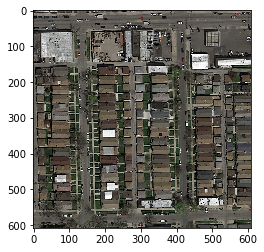

In [197]:
plt.imshow(test_data[0])

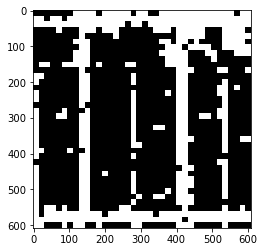

In [199]:
tmp_data = numpy.asarray(img_crop(test_data[0], IMG_PATCH_SIZE, IMG_PATCH_SIZE))
output_prediction = model.predict(tmp_data)
img = 1-label_to_img(608, 608, 16, 16, output_prediction)
img_s = label_to_img_soft(608, 608, 16, 16, output_prediction)
plt.imshow(img, cmap='Greys_r')

In [ ]:
submission_filename = 'silly_submission.csv'
images = [keras_prediction(model, test_data[i]) for i in range(test_data.shape[0])]
masks_to_submission(submission_filename, images, file_names)

In [274]:
from keras.models import load_model
model1 = load_model('FCN_16_enh.h5', custom_objects= {'f1_score': f1})
model2 = load_model('DilNet_16_enh.h5', custom_objects= {'f1': f1})
model3 = load_model('FCN_16_enh2.h5', custom_objects= {'f1': f1})

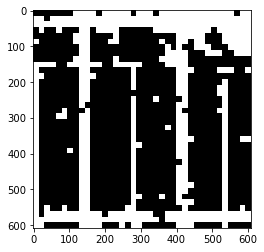

In [275]:
tmp_data = numpy.asarray(img_crop(test_data[0], IMG_PATCH_SIZE, IMG_PATCH_SIZE))
pred1 = model1.predict(tmp_data)
pred2 = 1 - model2.predict(tmp_data)
pred3 = 1 - model3.predict(tmp_data)
img = label_to_img(608, 608, 16, 16, (pred1 + pred2 + pred3)/3)
plt.imshow(img, cmap='Greys_r')

In [293]:
pred1 = 1-model1.predict(train_data)
pred2 = model2.predict(train_data)
pred3 = model3.predict(train_data)
res = (pred1 + pred2 + pred3) / 3

In [296]:
pred1_l = [1 if i > 0.5 else 0 for i in pred1]
pred2_l = [1 if i > 0.5 else 0 for i in pred2]
pred3_l = [1 if i > 0.5 else 0 for i in pred3]
res_l = [1 if i > 0.5 else 0 for i in (pred1 + pred2 + pred3) / 3]
res2_l = [1 if i > 0.5 else 0 for i in (pred1 + pred2) / 2]
f1_score(1-train_labels, pred1_l), f1_score(1-train_labels, pred2_l), f1_score(1-train_labels, pred3_l), f1_score(1-train_labels, res2_l), f1_score(1-train_labels, res_l)

(0.90583938541622944,
 0.91367007135861211,
 0.89681325111401178,
 0.91836886596841949,
 0.92067530563401534)

In [258]:
submission_filename = 'silly_submission.csv'
images = [keras_prediction_av(model1, model2, test_data[i]) for i in range(test_data.shape[0])]
masks_to_submission(submission_filename, images, file_names)

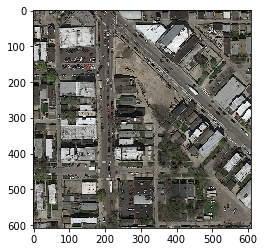

In [290]:
plt.imshow(test_data[10])

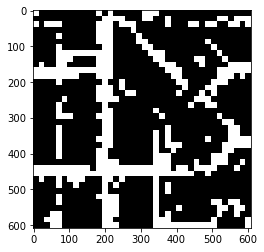

In [291]:
plt.imshow(keras_prediction_av(model1, model2, test_data[10]),cmap='Greys_r')

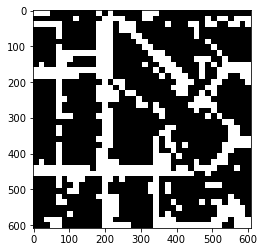

In [292]:
plt.imshow(keras_prediction_av3(model1, model2, model3, test_data[10]),cmap='Greys_r')

## CRF to smooth

In [178]:
import sys

from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
    create_pairwise_gaussian, softmax_to_unary

import skimage.io as io

image = test_data[49]
img_probs = np.array([[i, 1 - i] for i in img_s.ravel()]).T
img_probs.shape

(2, 369664)

In [179]:
unary = softmax_to_unary(img_probs)

# The inputs should be C-continious -- we are using Cython wrapper
unary = np.ascontiguousarray(unary)
unary.shape

(2, 369664)

In [182]:
d = dcrf.DenseCRF(image.shape[0] * image.shape[1], 2)

d.setUnaryEnergy(unary)

# This potential penalizes small pieces of segmentation that are
# spatially isolated -- enforces more spatially consistent segmentations
feats = create_pairwise_gaussian(sdims=(10, 10), shape=image.shape[:2])

d.addPairwiseEnergy(feats, compat=3,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)

# This creates the color-dependent features --
# because the segmentation that we get from CNN are too coarse
# and we can use local color features to refine them
feats = create_pairwise_bilateral(sdims=(50, 50), schan=(20, 20, 20),
                                   img=image, chdim=2)

d.addPairwiseEnergy(feats, compat=10,
                     kernel=dcrf.DIAG_KERNEL,
                     normalization=dcrf.NORMALIZE_SYMMETRIC)
Q = d.inference(5)

res = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))

AttributeError: module 'pydensecrf.densecrf' has no attribute 'DenseCRF'

In [ ]:
cmap = plt.get_cmap('bwr')
plt.imshow(res, vmax=1.5, vmin=-0.4, cmap=cmap)

## Random things testing....

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def label_to_img_lr(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

In [ ]:
from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(train_data.reshape((train_data.shape[0], -1)), np.argmax(train_labels, axis=1))

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(train_labels, logreg.predict(train_data.reshape((train_data.shape[0], -1))))

In [ ]:
tmp_data = numpy.asarray(img_crop(test_data[0], IMG_PATCH_SIZE, IMG_PATCH_SIZE))
output_prediction = logreg.predict(tmp_data.reshape(tmp_data.shape[0], -1))
plt.imshow(label_to_img_lr(608, 608, 16, 16, output_prediction), cmap='Greys_r')

## MLP from sklearn

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(32, 32, 64))
mlp.fit(train_data.reshape((train_data.shape[0], -1)), train_labels)
accuracy_score(train_labels, mlp.predict(train_data.reshape((train_data.shape[0], -1))))

In [ ]:
def sklearn_prediction(model, image):
    tmp_data = numpy.asarray(img_crop(image, IMG_PATCH_SIZE, IMG_PATCH_SIZE))
    output_prediction = model.predict(tmp_data.reshape(tmp_data.shape[0], -1))
    return label_to_img_lr(608, 608, 16, 16, output_prediction)

In [ ]:
tmp_data = numpy.asarray(img_crop(test_data[3], IMG_PATCH_SIZE, IMG_PATCH_SIZE))
output_prediction = mlp.predict(tmp_data.reshape(tmp_data.shape[0], -1))
plt.imshow(label_to_img_lr(608, 608, 16, 16, output_prediction), cmap='Greys_r')